In [228]:
# Library imports
from category_encoders.target_encoder import TargetEncoder
from contextlib import suppress
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from IPython.display import display
from sklearn.metrics import r2_score, PredictionErrorDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import xgboost as xgb
from xgboost import plot_importance, XGBRegressor
import time
from datetime import datetime

In [229]:
# Record and display execution start time
start_time = time.time()
now = datetime.now()
print(now.strftime("%d/%m/%Y %H:%M:%S"))

09/04/2025 23:12:42


In [230]:
def load_dataset(
        target='Tensile modulus retention',
        file_path=str(os.getcwd()) + '\\Entradas\\degrad_dataset.csv',
        min_target_counts=1,
        cols_to_drop=['Author',
            'Isophtalic polyester resin',
            'Orthophtalic polyester resin',
            'Vinylester resin',
            'Phenolic resin',
            'Epoxy resin',
            'Glass fiber',
            'Carbon fiber',
            'Pultrusion',
            'Hand lay-up',
            'Filament winding',
            'VARTM',
            'Coupon descr.',
            'Aging effect',
            'Steady condition',
            'Cyclic condition',
            'Immersion',
            'Moisture',
            'Presence of salts',
            'Exposure time (hours)',
            'Min. exposure temperature (ºC)',
            'Max. exposure temperature (ºC)',
            'Residual tensile modulus (GPa)'
            ]
        ):
    """Read and process a .CSV file into a filtered pandas DataFrame.

    Args:
        target (string): Column name of the target property.
        min_target_counts (int | float): Minimum count threshold for target
            values. Rows with values appearing fewer times are dropped.
    
    Returns:
        pandas.DataFrame: Filtered dataset with only relevant columns. Rows
            with values appearing fewer times are dropped.
    
    Notes:
        The .CSV file path is hardcoded in this version and not
            user-configurable
        XGBoost is sparsity-aware. No need to drop missing values.
    """

    # Read .CSV as pandas dataframe
    df = pd.read_csv(file_path, delimiter=';')

    # Drop columns that are not important for the analysis
    df = df.drop(columns=cols_to_drop)

    # Remove unnamed columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # Filters target property values that appear less than min_target_count times
    value_counts = df[target].value_counts()
    valid_values = value_counts[value_counts > min_target_counts - 1].index
    df = df[df[target].isin(valid_values)]

    return df

In [231]:
def get_abs_error(y_test, y_pred):  
    """Calculate the maximum signed absolute error between predicted and actual
        values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: Maximum signed absolute error (y_pred - y_test), rounded to
                3 decimals.
        
        Notes:
            Positive values indicate overprediction, negative underprediction.
            Both inputs must have the same length.    
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_abs_error(y_test, y_pred)
        -0.4
    """
    
    y_test = y_test.tolist()
    a = []
    for i in range(len(y_test)):
        a.append((y_pred[i] - y_test[i]))
        
    abs_error=0
    if max(abs(i) for i in a) == max(a):
        abs_error = max(a)
    else:
        abs_error = min(a)

    return round(abs_error, 3)

In [232]:
def get_rel_error(y_test, y_pred):
    """Calculate the maximum signed relative error between predicted and actual
        values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: Maximum signed relative error ((y_pred - y_test) / y_test),
                rounded to 3 decimals.
        
        Notes:
            Positive values indicate overprediction, negative underprediction.
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_rel_error(y_test, y_pred)
        -0.167
    """
    
    y_test = y_test.tolist()
    a = []
    for i in range(len(y_test)):
        a.append((y_pred[i] - y_test[i])/y_test[i])
        
    rel_error=0
    if max(abs(i) for i in a) == max(a):
        rel_error = max(a)
    else:
        rel_error = min(a)

    return round(rel_error, 3)

In [233]:
def get_mae(y_test, y_pred):
    """Calculate the mean absolute error (MAE) between predicted and actual values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: MAE (Σ(|y_pred - y_test|) / len(y_test)), rounded to 3 decimals.
        
        Note:
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_mae(y_test, y_pred)
        0.233
    """
    
    y_test = y_test.tolist()
    a = 0
    for i in range(len(y_test)):
        a = a + abs(y_pred[i] - y_test[i])
        
    mae = a / len(y_test)

    return round(mae, 3)

In [234]:
def get_rmse(y_test, y_pred):
    """Calculate the root mean squared error (RMSEA) between predicted and
        actual values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: RMSE ((Σ(|y_pred - y_test|)² / len(y_test))^0.5), rounded
                to 3 decimals.
        
        Note:
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_rmse(y_test, y_pred)
        0.265
    """
    
    y_test = y_test.tolist()
    a = 0
    for i in range(len(y_test)):
        a = a + (y_pred[i] - y_test[i]) ** 2
        
    rmse = np.sqrt(a / len(y_test))

    return round(rmse, 3)

In [235]:
def get_r2(y_test, y_pred):
    """Calculate the coefficient of determination (or R² score) of predicted
        values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: R² score (1 - RSS/TSS), rounded to 3 decimals.
        
        Note:
            RSS: Residual sum of squares (Σ(y_pred - y_test)²).
            TSS: Total sum of squares (Σ(mean - y_test)²), i.e., variability of
                the actual data.
            An R² score equal to 1 indicates a perfect fit between predicted and
                actual values. An R² equal to 0 means the prediction is no better
                than the mean. A negative R² indicates the prediction is worse
                than the mean.
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_r2(y_test, y_pred)
        0.978
    """
    
    y_test = y_test.tolist()
    mean = sum(y_test) / len(y_test)
    rss = 0  # Residual sum of squares
    tss = 0  # Total sum of squares
    for i in range(len(y_test)):
        rss = rss + (y_pred[i] - y_test[i]) ** 2
        tss = tss + (mean - y_test[i]) ** 2

    r2 = 1 - rss / tss

    return round(r2, 3)

In [236]:
class Predictor:
    def __init__(
        self,
        model_params: dict = {
            'encoder': TargetEncoder(),
            'clf': {
                'random_state': 0,
                'booster':      'gbtree',
                'base_score':   0.9,
                'eval_metric':  r2_score
                },
            'bayes_cv': {
                'search_space': {
                    'clf__max_depth':           Integer(2, 5),
                    'clf__n_estimators':        Integer(100, 500),
                    'clf__learning_rate':       Real(0.01, 0.2,
                        prior='log-uniform'),
                    'clf__subsample':           Real(0.7, 0.9),
                    'clf__colsample_bytree':    Real(0.7, 0.9),
                    'clf__reg_alpha':           Real(0.1, 1.0),
                    'clf__reg_lambda':          Real(0.1, 1.0),
                    'clf__gamma':               Real(0.0, 0.5),
                    },
                'cv':           5,
                'n_iter':       60,
                'scoring':      'r2',
                'n_jobs':       6
                }
            },
            target='Tensile modulus retention'
        ):
        self.model_params   = model_params
        self.target         = target
        self.dataset        = {
            'X'                 :0,
            'y'                 :0
        }
        self.n_runs         = 0
        self.trained_models = []
        self.overall_stats  = {
            'abs_error_mean'    :0,
            'abs_error_std'     :0,
            'rel_error_mean'    :0,
            'rel_error_std'     :0,
            'mae_mean'          :0,
            'mae_std'           :0,
            'rmse_mean'         :0,
            'rmse_std'          :0,
            'r2_mean'           :0,
            'r2_std'            :0
        }
        self.best_model     = None
    """Train XGBoost model with Bayesian optimization for hyperparameter tuning
        and predict the long-term property retention of aged FRP composites.

    Args:
        model_params (dict): Dictionary containing all model parameters.
            Structure:
            - encoder: Categorical variable encoder.
            - clf: Estimator parameters.
                - random_state (int): Seed for reproducibility.
                - booster (str): Booster type.
                - base_score (float): Initial prediction value.
                - eval_metric  (Union[str, List[str], Callable, NoneType]):
                    Metric for training result monitoring.
            - bayes_cv: Bayesian optimization parameters (hyperparameter tuning).
                - search_space: Hyperparameter ranges for optimization.
                - cv: Number of cross-validation folds.
                - n_iter: Number of hyperparameter combinations to test.
                - n_jobs: Number of CPU cores to be used in parallel.
        target (str): Target property.
    
    Attributes:
        - model_params (dict): Stored model parameters.
        - target (str): Stored target property.
        - dataset (dict): Stored dataset.
        - n_runs (int): Stored number of models to be trained.
        - trained_models (list): Will store models and metrics dicts after training.
        - overall_stats (dict): Will store statiscally treated errors and R² score.
        - best_model (XGBRegressor): Will store top-performing model.
    """

    def create_model(self):
        """Create model and configure the training pipeline with Bayesian
            optimization.

        Returns:
            skopt.BayesSearchCV: Configured Bayesian optimization search object ready
                for fitting.
        """
        
        estimators = [
            ('encoder', self.model_params['encoder']),
            ('clf', XGBRegressor(
                random_state    =self.model_params['clf']['random_state'],
                booster         =self.model_params['clf']['booster'],
                base_score      =self.model_params['clf']['base_score'],
                eval_metric     =self.model_params['clf']['eval_metric'],
                objective       ='reg:squarederror'
                )
            )
        ]
                
        opt = BayesSearchCV(
            Pipeline(steps=estimators),
            self.model_params['bayes_cv']['search_space'],
            cv                  = self.model_params['bayes_cv']['cv'],
            n_iter              = self.model_params['bayes_cv']['n_iter'],
            scoring             = self.model_params['bayes_cv']['scoring'],
            error_score         = 'raise',
            random_state        = 0,
            return_train_score  = True,
            n_jobs              = self.model_params['bayes_cv']['n_jobs'],
            n_points            = 1,
            verbose             = False
            )
        
        return opt

    def train(self, dataset, n_runs=10, q=5, test_size=0.2, best_metric='r2'):
        """Train n_runs models with different data splits, calculate and store
            their metrics.

        Args:
            dataset (pandas.DataFrame): Dataset.
            n_runs (int): Number of times the dataset will be split for new
                trainings. Default is 10.
            q (int): Number of quantiles in data stratification. Default is 5.
            test_size (int): Fraction of the dataset used for validation.
                Default is 0.2.
            best_metric (str): Metric defining the best model. Default is R².
        """

        # Create model
        model = self.create_model()

        # Load dataset
        df = dataset
        
        # Separate independent variables from target
        X = df.drop(columns=self.target)
        y = df[self.target]
        
        # Restart attributes
        self.dataset['X'] = X
        self.dataset['y'] = y
        self.n_runs = n_runs
        self.trained_models = []

        # Bin the continuous target into categories for stratification
        bins = pd.qcut(y, q=q, duplicates='drop')

        loop_start = time.time()
        for i in range(n_runs):
            
            # Split data in training and test groups
            X_train, X_test, y_train, y_test = train_test_split(X, y,
                test_size=test_size, stratify=bins, random_state=i)
        
            # Train model
            print('Starting fit #', i, sep='')
            fit_start = time.time()
            print(datetime.now().strftime("%d/%m/%Y %H:%M:%S\n"))
            model.fit(X_train, y_train)
            fit_finish = time.time()
            print('Fit #', i, ' is finished! (%s s)\n'
                % round((fit_finish - fit_start), 1), sep='')
            if i == n_runs - 1:
                print('Total training duration: %s s\n'
                    % round((fit_finish - loop_start), 1), sep='')
            y_pred = model.predict(X_test)
            model_info = {
                'id': i,
                'model': model.best_estimator_,
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_pred': y_pred,
                'y_test': y_test,
                'abs_error': get_abs_error(y_test, y_pred),
                'rel_error': get_rel_error(y_test, y_pred),
                'mae': get_mae(y_test, y_pred),
                'rmse': get_rmse(y_test, y_pred),
                'r2': get_r2(y_test, y_pred),
                'best_cv_score': model.best_score_,
                'best_params': model.best_params_,
                'importance_plot': model.best_estimator_.steps[1][1],
                'importance_score': model.best_estimator_.steps[1][1].
                    get_booster().get_score(importance_type='weight')
                }
            self.trained_models.append(model_info)
        
        # Extract metrics, calculate and store statistics
        abs_error = [self.trained_models[i]['abs_error']
            for i in range(len(self.trained_models))]
        abs_error_mean = np.mean(abs_error)
        abs_error_std = np.std(abs_error)
        self.overall_stats['abs_error_mean'] = abs_error_mean
        self.overall_stats['abs_error_std'] = abs_error_std
        print(f"Abs. error: {abs_error_mean:.3f} ± {abs_error_std:.3f}")

        rel_error = [self.trained_models[i]['rel_error']
            for i in range(len(self.trained_models))]
        rel_error_mean = np.mean(rel_error)
        rel_error_std = np.std(rel_error)
        self.overall_stats['rel_error_mean'] = rel_error_mean
        self.overall_stats['rel_error_std'] = rel_error_std
        print(f"Rel. error: {rel_error_mean:.3f} ± {rel_error_std:.3f}")

        mae = [self.trained_models[i]['mae']
            for i in range(len(self.trained_models))]
        mae_mean = np.mean(mae)
        mae_std = np.std(mae)
        self.overall_stats['mae_mean'] = mae_mean
        self.overall_stats['mae_std'] = mae_std
        print(f"MAE: {mae_mean:.3f} ± {mae_std:.3f}")

        rmse = [self.trained_models[i]['rmse']
            for i in range(len(self.trained_models))]
        rmse_mean = np.mean(rmse)
        rmse_std = np.std(rmse)
        self.overall_stats['rmse_mean'] = rmse_mean
        self.overall_stats['rmse_std'] = rmse_std
        print(f"RMSE: {rmse_mean:.3f} ± {rmse_std:.3f}")

        r2 = [self.trained_models[i]['r2']
            for i in range(len(self.trained_models))]
        r2_mean = np.mean(r2)
        r2_std = np.std(r2)
        self.overall_stats['r2_mean'] = r2_mean
        self.overall_stats['r2_std'] = r2_std
        print(f"R²: {r2_mean:.2f} ± {r2_std:.2f}\n")
    
        # Store the best model
        best_model = max(self.trained_models, key=lambda x: x['r2'])
        self.best_model = best_model
    
    def bootstrap(self):
        """Calc...
        """

        metrics = {
            'mae': [],
            'rmse': [],
            'r2': []
        }

        model = self.best_model

    def predict(self, model):
        pass

In [237]:
predictor = Predictor()

In [238]:
dataset = load_dataset()
predictor.train(dataset=dataset, n_runs=5)

Starting fit #0
09/04/2025 23:12:42

Fit #0 is finished! (86.4 s)

Starting fit #1
09/04/2025 23:14:08

Fit #1 is finished! (81.6 s)

Starting fit #2
09/04/2025 23:15:30

Fit #2 is finished! (70.6 s)

Starting fit #3
09/04/2025 23:16:41

Fit #3 is finished! (63.2 s)

Starting fit #4
09/04/2025 23:17:44

Fit #4 is finished! (62.1 s)

Total training duration: 363.9 s

Abs. error: -0.036 ± 0.254
Rel. error: 0.016 ± 0.298
MAE: 0.044 ± 0.001
RMSE: 0.064 ± 0.005
R²: 0.66 ± 0.08



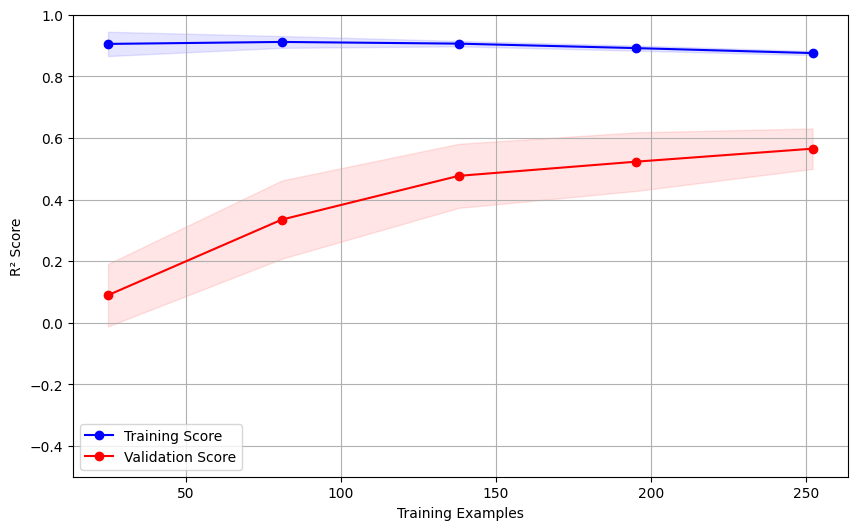

In [239]:
# Separate independent variables from target
X = predictor.dataset['X']
y = predictor.dataset['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from sklearn.model_selection import learning_curve  
train_sizes, train_scores, test_scores = learning_curve(  
    predictor.trained_models[0]['model'], X_train, y_train, cv=5, scoring='r2'  
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='red', label='Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
plt.xlabel("Training Examples")
plt.ylabel("R² Score")
plt.ylim(-0.5, 1.0)  # Adjust based on your scores
plt.legend()
plt.grid()
plt.show()

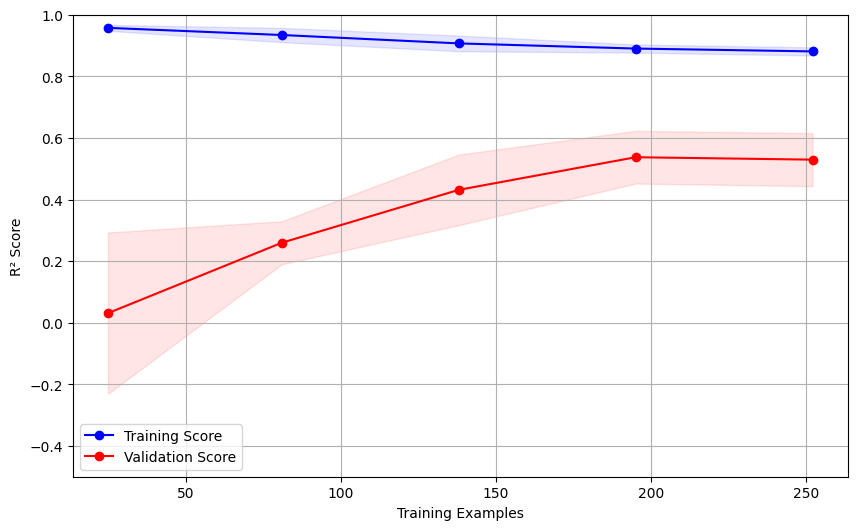

In [240]:
df = load_dataset()
# df.head()

# Separate independent variables from target
X = df.drop(columns=['Tensile modulus retention'])
y = df['Tensile modulus retention']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from sklearn.model_selection import learning_curve  
train_sizes, train_scores, test_scores = learning_curve(  
    predictor.trained_models[0]['model'], X_train, y_train, cv=5, scoring='r2'  
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='red', label='Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
plt.xlabel("Training Examples")
plt.ylabel("R² Score")
plt.ylim(-0.5, 1.0)  # Adjust based on your scores
plt.legend()
plt.grid()
plt.show()

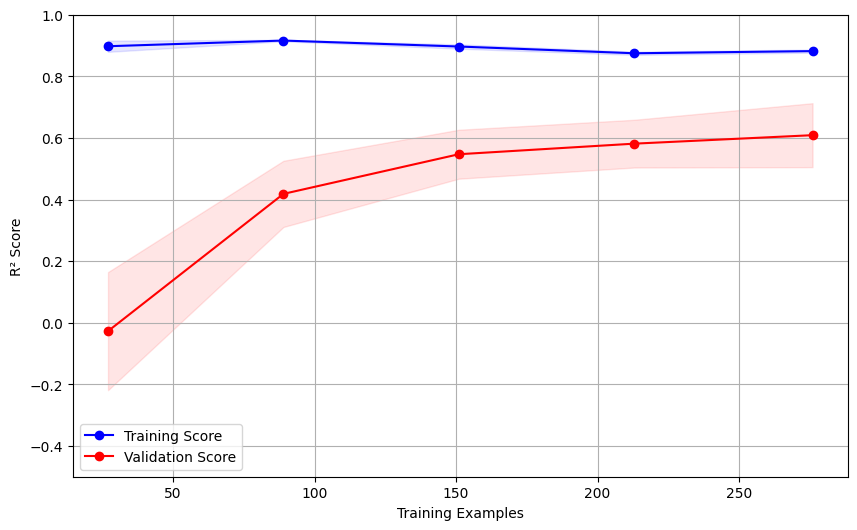

In [241]:
df = load_dataset()
# df.head()

# Separate independent variables from target
X = df.drop(columns=['Tensile modulus retention'])
y = df['Tensile modulus retention']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from sklearn.model_selection import learning_curve  
train_sizes, train_scores, test_scores = learning_curve(  
    predictor.trained_models[0]['model'], X_train, y_train, cv=8, scoring='r2'  
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='red', label='Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
plt.xlabel("Training Examples")
plt.ylabel("R² Score")
plt.ylim(-0.5, 1.0)  # Adjust based on your scores
plt.legend()
plt.grid()
plt.show()

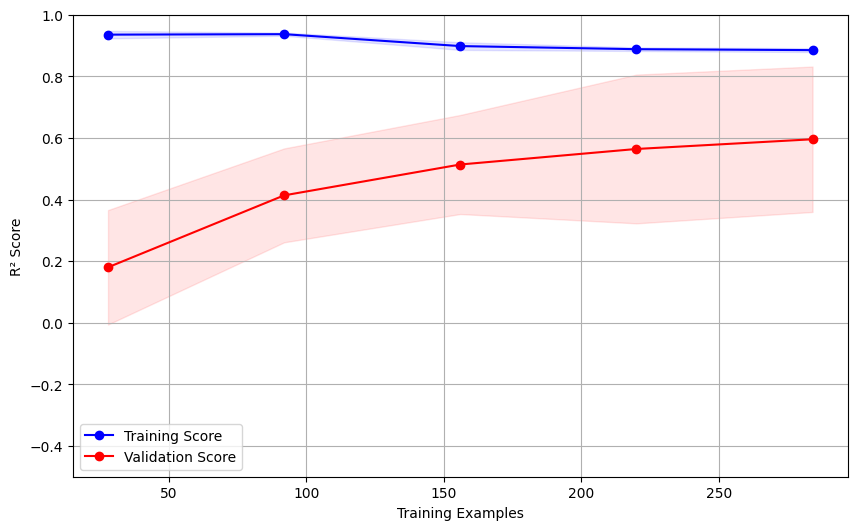

In [242]:
df = load_dataset()
# df.head()

# Separate independent variables from target
X = df.drop(columns=['Tensile modulus retention'])
y = df['Tensile modulus retention']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from sklearn.model_selection import learning_curve  
train_sizes, train_scores, test_scores = learning_curve(  
    predictor.trained_models[0]['model'], X_train, y_train, cv=10, scoring='r2'  
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='red', label='Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
plt.xlabel("Training Examples")
plt.ylabel("R² Score")
plt.ylim(-0.5, 1.0)  # Adjust based on your scores
plt.legend()
plt.grid()
plt.show()

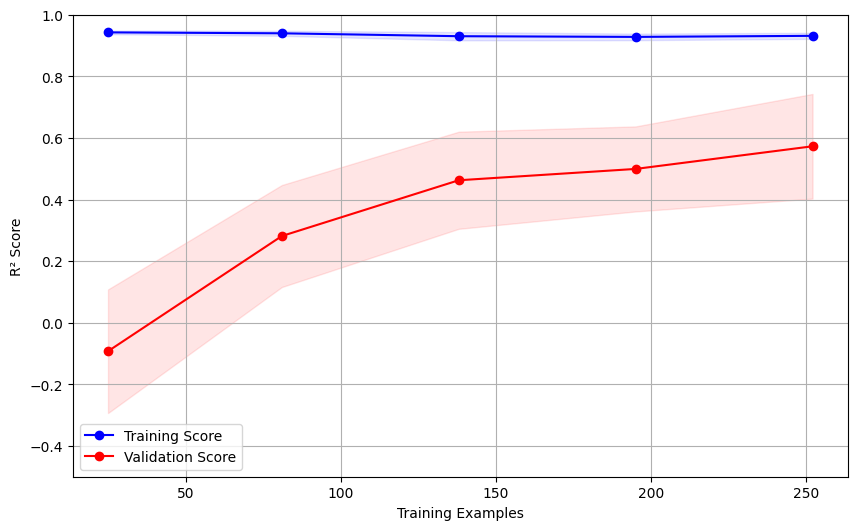

In [243]:
df = load_dataset()
# df.head()

# Separate independent variables from target
X = df.drop(columns=['Tensile modulus retention'])
y = df['Tensile modulus retention']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from sklearn.model_selection import learning_curve  
train_sizes, train_scores, test_scores = learning_curve(  
    predictor.best_model['model'], X_train, y_train, cv=5, scoring='r2'  
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='red', label='Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
plt.xlabel("Training Examples")
plt.ylabel("R² Score")
plt.ylim(-0.5, 1.0)  # Adjust based on your scores
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

# Outer CV: Evaluate performance
outer_scores = cross_val_score(
    predictor.trained_models[0]['model'], predictor.dataset['X'], predictor.dataset['y'], 
    cv=KFold(5), 
    scoring='r2'
)
print(f"Unbiased R²: {np.mean(outer_scores):.3f} ± {np.std(outer_scores):.3f}")

Unbiased R²: -1.105 ± 0.573


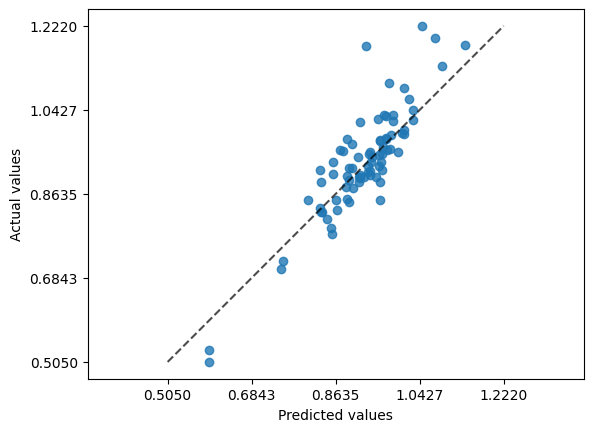

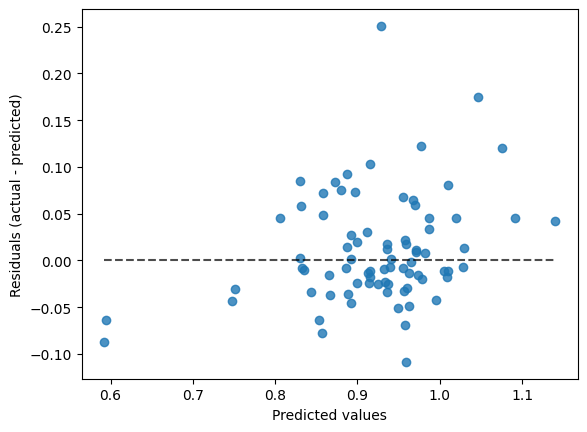

In [245]:
display = PredictionErrorDisplay.from_predictions(predictor.best_model['y_test'],
    predictor.best_model['y_pred'], kind="actual_vs_predicted")
display.plot()
plt.show()

In [246]:
# importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
predictor.best_model['importance_score']

{'Type of resin': 400.0,
 'Manufacturing process': 143.0,
 'V_f': 1048.0,
 'Coupon thick. (mm)': 617.0,
 'Salt conc. (g/L)': 558.0,
 'pH': 285.0,
 'Relative humidity': 366.0,
 'Sustained loading': 260.0,
 'Exposure time (days)': 2395.0,
 'Avg. exposure temperature (ºC)': 1047.0,
 'Temperature range (ºC)': 94.0,
 'Unaged tensile modulus (GPa)': 899.0}

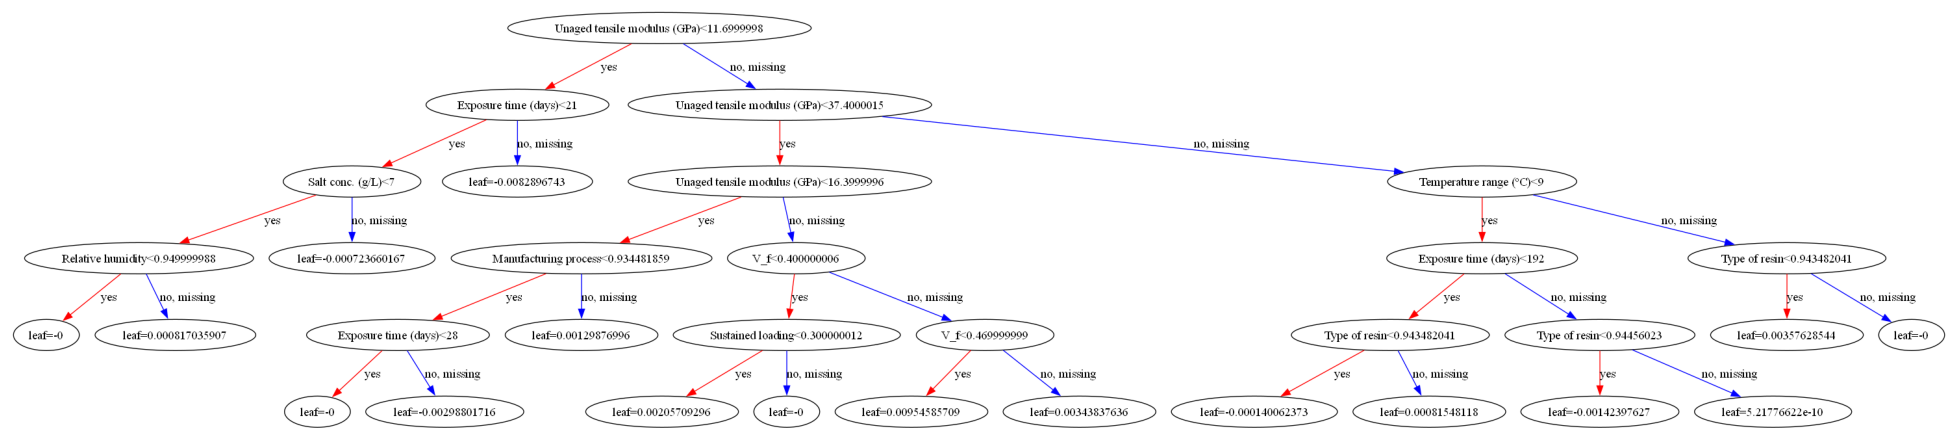

In [247]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(25,10))
    ax = fig.add_subplot(111)
    xgb.plotting.plot_tree(predictor.best_model['importance_plot'], ax=ax, num_trees=0)

In [248]:
# Fim do processamento
now = datetime.now()

print(now.strftime("%d/%m/%Y %H:%M:%S"))
print("\nProcessing time: %s seconds\n" % (round((time.time() - start_time), 2)))

09/04/2025 23:19:06

Processing time: 384.11 seconds

